In [55]:
%matplotlib inline

import pandas as pd

# データの読み込み（データセット中のYのみロード）
dataframe = pd.read_csv('/content/drive/MyDrive/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values.astype('float32')

In [56]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [57]:
# 訓練データとテストデータを分割（時系列の予測が目的のため、ある時点から先をテストデータとする）
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [88]:
import numpy as np

# X=[data[t-look_back],...,data[t-1]], Y=data[t]となるデータセットに変換
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# [samples, time steps, features]へ変形（LSTMに与える入力は (サンプル, 時刻, 特徴量の次元) の3次元になる。）
# see: https://own-search-and-study.xyz/2018/09/17/keras%E3%81%A7lstm%E3%82%92%E5%AD%A6%E7%BF%92%E3%81%99%E3%82%8B%E6%89%8B%E9%A0%86%E3%82%92%E6%95%B4%E7%90%86%E3%81%97%E3%81%A6%E3%81%BF%E3%81%9F/
#      https://qiita.com/everylittle/items/ba821e93d275a421ca2b
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM

# LSTMにDenseを接続し、数値を予測（MSEで評価）
model = Sequential()

model.add(LSTM(4, input_shape=(look_back, 1))) # input_shape=(系列長T, x_tの次元), output_shape=(units,)
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [60]:
model.fit(trainX, trainY, batch_size=1, epochs=100, verbose=2)

Epoch 1/100
92/92 - 1s - loss: 0.0949 - 1s/epoch - 16ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0401 - 218ms/epoch - 2ms/step
Epoch 3/100
92/92 - 0s - loss: 0.0291 - 216ms/epoch - 2ms/step
Epoch 4/100
92/92 - 0s - loss: 0.0254 - 217ms/epoch - 2ms/step
Epoch 5/100
92/92 - 0s - loss: 0.0226 - 216ms/epoch - 2ms/step
Epoch 6/100
92/92 - 0s - loss: 0.0201 - 221ms/epoch - 2ms/step
Epoch 7/100
92/92 - 0s - loss: 0.0179 - 214ms/epoch - 2ms/step
Epoch 8/100
92/92 - 0s - loss: 0.0158 - 220ms/epoch - 2ms/step
Epoch 9/100
92/92 - 0s - loss: 0.0138 - 215ms/epoch - 2ms/step
Epoch 10/100
92/92 - 0s - loss: 0.0120 - 205ms/epoch - 2ms/step
Epoch 11/100
92/92 - 0s - loss: 0.0104 - 224ms/epoch - 2ms/step
Epoch 12/100
92/92 - 0s - loss: 0.0090 - 218ms/epoch - 2ms/step
Epoch 13/100
92/92 - 0s - loss: 0.0079 - 215ms/epoch - 2ms/step
Epoch 14/100
92/92 - 0s - loss: 0.0067 - 218ms/epoch - 2ms/step
Epoch 15/100
92/92 - 0s - loss: 0.0061 - 216ms/epoch - 2ms/step
Epoch 16/100
92/92 - 0s - loss: 0.0057 - 227ms/epoc

In [61]:
import math
from sklearn.metrics import mean_squared_error

# テストデータに対する予測（評価のため訓練データも）
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 正規化を元に戻す
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 平均二乗誤差のルートで評価
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 27.79
Test RMSE: 62.47


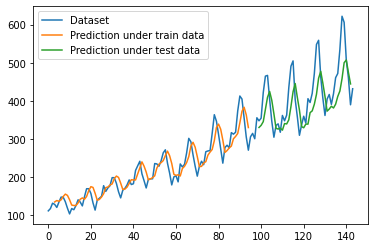

In [77]:
from sklearn.utils.fixes import threadpool_info
import matplotlib.pyplot as plt

# 訓練データ部分の予測データ
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# テストデータ部分の予測データ
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset), label='Dataset')
plt.plot(trainPredictPlot, label='Prediction under train data')
plt.plot(testPredictPlot, label='Prediction under test data')
plt.legend()
plt.show()

In [79]:
# from IPython.display import SVG
# from tensorflow.python.keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model).create(prog='dot', format='svg'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 4)                 96        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
